In [1]:
# %pip install scikit-learn
# %pip install plotly -quiet

In [2]:
%reset -f

from sklearn.cluster import KMeans
import pandas as pd
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from matplotlib import pyplot as plt

In [3]:
pd.set_option("display.max_row", 5)

df = pd.read_csv(r"D:\GALEN ANANTA\UNIVERSITAS PADJADJARAN\K U L I A H\SEMS 6\MATSAINS\Presentasi\Chocolate Sales.csv")
df

,Sales Person,Country,Product,Date,Amount,Boxes Shipped
0,Jehu Rudeforth,UK,Mint Chip Choco,04-Jan-22,"$5,320",180
1,Van Tuxwell,India,85% Dark Bars,01-Aug-22,"$7,896",94
...,...,...,...,...,...,...
1092,Dotty Strutley,India,Eclairs,28-Jul-22,"$2,086",384
1093,Karlen McCaffrey,India,70% Dark Bites,23-May-22,"$5,075",344


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1094 entries, 0 to 1093
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Sales Person   1094 non-null   object
 1   Country        1094 non-null   object
 2   Product        1094 non-null   object
 3   Date           1094 non-null   object
 4   Amount         1094 non-null   object
 5   Boxes Shipped  1094 non-null   int64 
dtypes: int64(1), object(5)
memory usage: 51.4+ KB


# Data Cleaning

In [5]:
df_clean = df.copy()

df_clean["Amount"] = df_clean["Amount"].replace(r'[\$,]', '', regex=True).astype(int) # Reformating Amount from object to int
df_clean['Date'] = pd.to_datetime(df_clean['Date'], format='%d-%b-%y').dt.date # Reformating Datetime

In [6]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1094 entries, 0 to 1093
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Sales Person   1094 non-null   object
 1   Country        1094 non-null   object
 2   Product        1094 non-null   object
 3   Date           1094 non-null   object
 4   Amount         1094 non-null   int64 
 5   Boxes Shipped  1094 non-null   int64 
dtypes: int64(2), object(4)
memory usage: 51.4+ KB


In [7]:
pd.set_option("display.max_row", 100)

df_clean.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Sales Person,1094,25,Kelci Walkden,54,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Country,1094,6,Australia,205,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Product,1094,22,Eclairs,60,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Date,1094,168,2022-06-30,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Amount,1094.0,NaN,NaN,NaN,5652.308044,4102.442014,7.0,2390.5,4868.5,8027.25,22050.0
Boxes Shipped,1094.0,NaN,NaN,NaN,161.797989,121.544145,1.0,70.0,135.0,228.75,709.0


# Data Understanding

In [8]:
# Rata-rata total penjualan per bulan
df_clean['Date'] = pd.to_datetime(df_clean['Date'])
df_clean['Month'] = df_clean['Date'].dt.to_period('M')


sales_month_avg = df_clean.groupby('Month')['Amount'].mean().reset_index()
sales_month_avg['Month'] = sales_month_avg['Month'].astype(str)

# Plot
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=sales_month_avg['Month'],
    y=sales_month_avg['Amount'],
    mode='lines+markers',
    line=dict(color='mediumseagreen', width=3),
    marker=dict(size=8, symbol='circle'),
    name='Rata-rata Penjualan',
    hovertemplate='%{x|%B %Y}<br><b>$%{y:,.2f}</b><extra></extra>'
))

fig.update_layout(
    title={
        'text': 'Rata-rata Penjualan per Bulan (USD)<br><span style="font-size:14px; color:gray;">Rata-rata penjualan bulan Juni berada pada posisi paling rendah</span>',
        'y': 0.9,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    xaxis_title='Bulan',
    yaxis_title='Rata-rata Penjualan ($)',
    template='plotly_white',
    yaxis_tickprefix='$',
    margin=dict(l=40, r=30, t=60, b=40)
)

fig.show()


In [9]:
# Hitung rata-rata penjualan per bulan per negara
df_clean['Date'] = pd.to_datetime(df_clean['Date'])
df_clean['Month'] = df_clean['Date'].dt.to_period('M').dt.to_timestamp()

avg_per_country_month = df_clean.groupby(['Country', 'Month'])['Amount'].mean().reset_index()

# List negara
countries = avg_per_country_month['Country'].unique()


fig = go.Figure()


for i, country in enumerate(countries):
    data = avg_per_country_month[avg_per_country_month['Country'] == country]
    visible = True if i == 0 else False  
    fig.add_trace(go.Scatter(
        x=data['Month'],
        y=data['Amount'],
        mode='lines+markers',
        name=country,
        visible=visible,
        line=dict(width=2),
        hovertemplate=f'{country}<br>Bulan: %{{x|%b %Y}}<br>Rata-rata: $%{{y:,.2f}}<extra></extra>'
    ))

# Buat dropdown menu
dropdown_buttons = []

for i, country in enumerate(countries):
    visibility = [False] * len(countries)
    visibility[i] = True  

    dropdown_buttons.append(dict(
        label=country,
        method='update',
        args=[{'visible': visibility},
              {'title': f'Rata-rata Penjualan Bulanan –'}]
    ))

# dropdown
fig.update_layout(
    updatemenus=[
        dict(
            active=0,
            buttons=dropdown_buttons,
            x=0.556,
            y=1.25,
            xanchor='left',
            yanchor='top',
            showactive=True
        )
    ],
    title=dict(
        text=f'Rata-rata Penjualan Bulanan –',
        x=0.47,
        xanchor='center',
        y=0.92,
        yanchor='top'
    ),
    annotations=[
        dict(
            text="Australia, Canada, dan USA menjadi negara penyebab penurunan rata-rata penjualan pada bulan Juni<br>Negara Canada dan UK dapat berpotensi mengalami penurunan rata-rata penjualan pada bulan depan</span>",
            xref="paper", yref="paper",
            x=0.5, y=1.08,
            showarrow=False,
            font=dict(size=14, color="gray"),
            xanchor='center'
        )
    ],
    xaxis_title='Bulan',
    yaxis_title='Rata-rata Penjualan (USD)',
    template='plotly_white',
    yaxis_tickprefix='$',
    margin=dict(l=40, r=30, t=100, b=40)
)


fig.show()


In [10]:
df_clean['Date'] = pd.to_datetime(df_clean['Date'])
df_clean['Month'] = df_clean['Date'].dt.to_period('M').dt.to_timestamp()

target_months = pd.to_datetime(['2022-06-01', '2022-07-01', '2022-08-01'])
filtered_df = df_clean[df_clean['Month'].isin(target_months)]

monthly_avg = (
    filtered_df.groupby(['Month', 'Product'])['Amount']
    .mean()
    .reset_index()
)

monthly_avg['below_month_avg'] = False

for month, group in monthly_avg.groupby('Month'):
    threshold = group['Amount'].mean()
    monthly_avg.loc[group.index, 'below_month_avg'] = group['Amount'] < threshold

below_counts = (
    monthly_avg[monthly_avg['below_month_avg']]
    .groupby('Product')
    .size()
    .reset_index(name='n_bulan_di_bawah_rata2')
)

produk_konsisten_rendah = below_counts[below_counts['n_bulan_di_bawah_rata2'] == 3]

final_df = monthly_avg.merge(produk_konsisten_rendah[['Product']], on='Product')

In [11]:
soft_colors = {
    'Produk A': 'rgba(135, 206, 250, 0.6)',   
    'Produk B': 'rgba(255, 160, 122, 0.6)',   
}

fig = px.bar(final_df,
             x='Month',
             y='Amount',
             color='Product',
             color_discrete_map=soft_colors,
             barmode='group',
             title='Produk dengan Penjualan Konsisten di Bawah Rata-rata (Juni–Agustus)',
             labels={'Amount': 'Rata-rata Penjualan (USD)', 'Month': 'Bulan'},
             text_auto='.2s')

fig.update_layout(
    colorway=['#A1D6E2', '#FFB6B9', '#B5EAD7', '#E2F0CB'],
    template='plotly_white',
    yaxis_tickprefix='$',
    xaxis_type='category',
    legend_title='Produk',
    margin=dict(l=40, r=30, t=60, b=40)
)

fig.show()

# Cleaning Data

In [12]:
cleaned_df = df_clean.iloc[:,:6]
cleaned_df

,Sales Person,Country,Product,Date,Amount,Boxes Shipped
0,Jehu Rudeforth,UK,Mint Chip Choco,2022-01-04,5320,180
1,Van Tuxwell,India,85% Dark Bars,2022-08-01,7896,94
2,Gigi Bohling,India,Peanut Butter Cubes,2022-07-07,4501,91
3,Jan Morforth,Australia,Peanut Butter Cubes,2022-04-27,12726,342
4,Jehu Rudeforth,UK,Peanut Butter Cubes,2022-02-24,13685,184
...,...,...,...,...,...,...
1089,Karlen McCaffrey,Australia,Spicy Special Slims,2022-05-17,4410,323
1090,Jehu Rudeforth,USA,White Choc,2022-06-07,6559,119
1091,Ches Bonnell,Canada,Organic Choco Syrup,2022-07-26,574,217
1092,Dotty Strutley,India,Eclairs,2022-07-28,2086,384


In [13]:
cleaned_df["Unit Price"] = cleaned_df["Amount"] / cleaned_df["Boxes Shipped"]

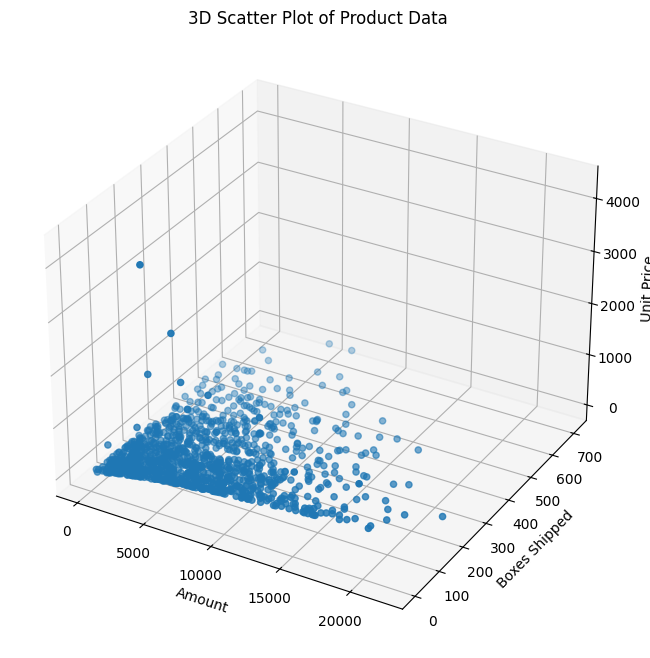

In [14]:
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(projection="3d")

scatter = ax.scatter(cleaned_df["Amount"], cleaned_df["Boxes Shipped"], cleaned_df["Unit Price"])

ax.set_xlabel('Amount')
ax.set_ylabel('Boxes Shipped')
ax.set_zlabel('Unit Price')

ax.set_title('3D Scatter Plot of Product Data')

plt.show()

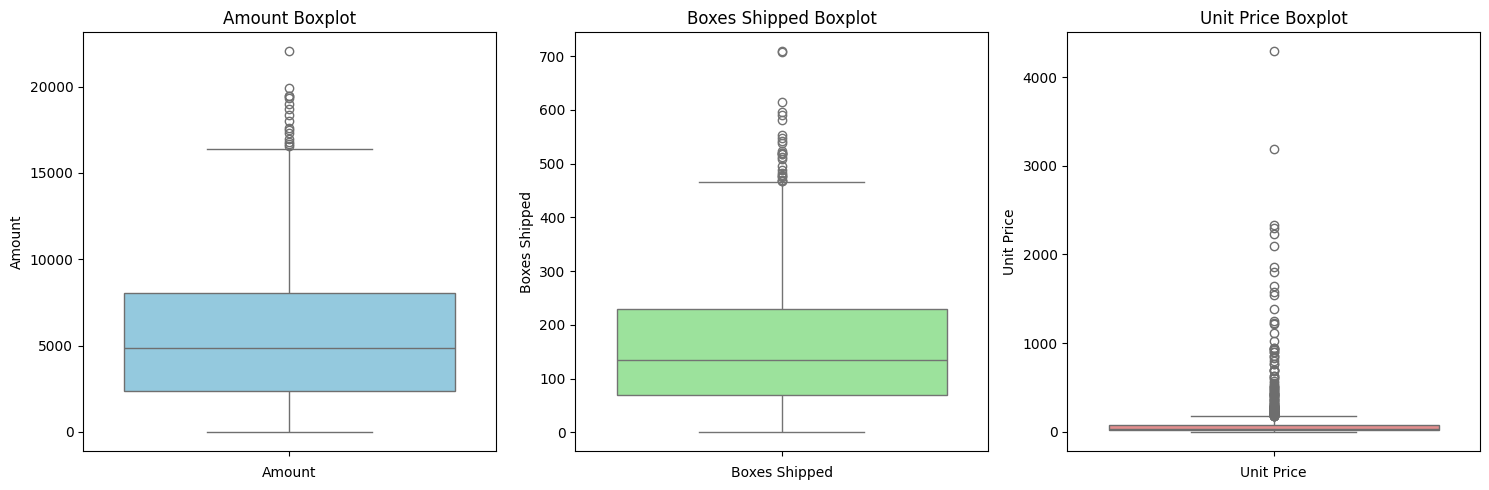

In [15]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.boxplot(data=cleaned_df["Amount"], color='skyblue')
plt.title('Amount Boxplot')
plt.xlabel('Amount')

plt.subplot(1, 3, 2)
sns.boxplot(data=cleaned_df["Boxes Shipped"], color='lightgreen')
plt.title('Boxes Shipped Boxplot')
plt.xlabel('Boxes Shipped')

plt.subplot(1, 3, 3)
sns.boxplot(data=cleaned_df["Unit Price"], color='lightcoral')
plt.title('Unit Price Boxplot')
plt.xlabel('Unit Price')

plt.tight_layout()
plt.show()

In [16]:
A_Q1 = cleaned_df["Amount"].quantile(0.25)
A_Q3 = cleaned_df["Amount"].quantile(0.75)
A_IQR = A_Q3 - A_Q1

amount_outliers_df = cleaned_df[(cleaned_df["Amount"] > (A_Q3 + 1.5 * A_IQR)) | (cleaned_df["Amount"] < (A_Q1 - 1.5 * A_IQR))].copy()

# amount_outliers_df.describe()

In [17]:
B_Q1 = cleaned_df["Boxes Shipped"].quantile(0.25)
B_Q3 = cleaned_df["Boxes Shipped"].quantile(0.75)
B_IQR = B_Q3 - B_Q1

boxesshipped_outliers_df = cleaned_df[(cleaned_df["Boxes Shipped"] > (B_Q3 + 1.5 * B_IQR)) | (cleaned_df["Boxes Shipped"] < (B_Q1 - 1.5 * B_IQR))].copy()

# boxesshipped_outliers_df.describe()

In [18]:
C_Q1 = cleaned_df["Unit Price"].quantile(0.25)
C_Q3 = cleaned_df["Unit Price"].quantile(0.75)
C_IQR = B_Q3 - B_Q1

unitprice_outliers_df = cleaned_df[(cleaned_df["Unit Price"] > (C_Q3 + 1.5 * C_IQR)) | (cleaned_df["Unit Price"] < (C_Q1 - 1.5 * C_IQR))].copy()

# unitprice_outliers_df.describe()

In [19]:
non_outliers_df = cleaned_df[(
    ~cleaned_df.index.isin(amount_outliers_df.index)) & 
    (~cleaned_df.index.isin(boxesshipped_outliers_df.index)) &
    (~cleaned_df.index.isin(unitprice_outliers_df.index))]

# non_outliers_df.describe()

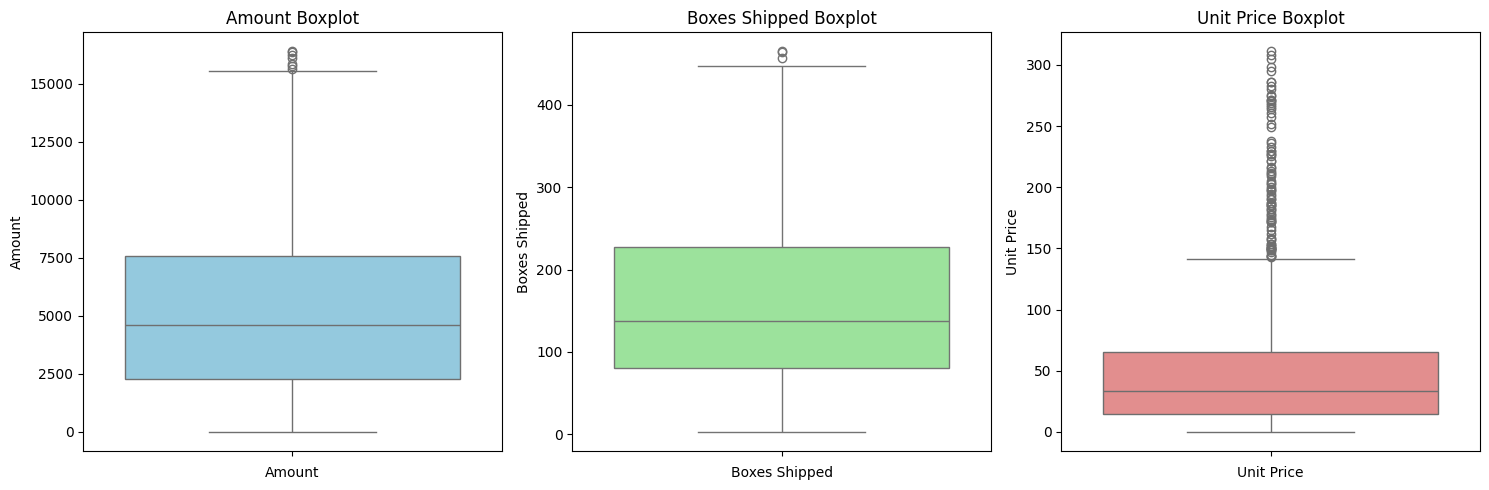

In [20]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.boxplot(data=non_outliers_df["Amount"], color='skyblue')
plt.title('Amount Boxplot')
plt.xlabel('Amount')

plt.subplot(1, 3, 2)
sns.boxplot(data=non_outliers_df["Boxes Shipped"], color='lightgreen')
plt.title('Boxes Shipped Boxplot')
plt.xlabel('Boxes Shipped')

plt.subplot(1, 3, 3)
sns.boxplot(data=non_outliers_df["Unit Price"], color='lightcoral')
plt.title('Unit Price Boxplot')
plt.xlabel('Unit Price')

plt.tight_layout()
plt.show()

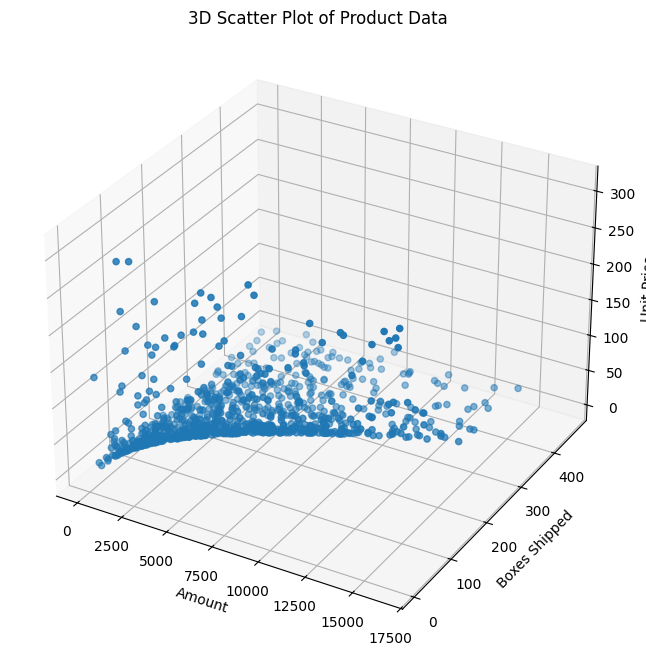

In [21]:
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(projection="3d")

scatter = ax.scatter(non_outliers_df["Amount"], non_outliers_df["Boxes Shipped"], non_outliers_df["Unit Price"])

ax.set_xlabel('Amount')
ax.set_ylabel('Boxes Shipped')
ax.set_zlabel('Unit Price')

ax.set_title('3D Scatter Plot of Product Data')

plt.show()

# Normalisasi Data

In [22]:
scaler = StandardScaler()

scaled_data = scaler.fit_transform(non_outliers_df.iloc[:, 4:7])
scaled_data

array([[ 0.0117793 ,  0.17423938, -0.39943954],
       [ 0.69676628, -0.64686804,  0.52304942],
       [-0.20600189, -0.67551133, -0.06215904],
       ...,
       [-1.25023476,  0.52750652, -0.8554005 ],
       [-0.84817719,  2.12198256, -0.80817627],
       [-0.05336892,  1.74007213, -0.6502508 ]], shape=(987, 3))

In [23]:
scaled_data_df = pd.DataFrame(scaled_data, columns=("Amount", "Boxes Shipped", "Unit Price"))
scaled_data_df

,Amount,Boxes Shipped,Unit Price
0,0.011779,0.174239,-0.399440
1,0.696766,-0.646868,0.523049
2,-0.206002,-0.675511,-0.062159
3,1.981117,1.720977,-0.269736
4,2.236126,0.212430,0.359967
...,...,...,...
982,-0.230200,1.539569,-0.668883
983,0.341243,-0.408174,0.033676
984,-1.250235,0.527507,-0.855401
985,-0.848177,2.121983,-0.808176


# Plot Data

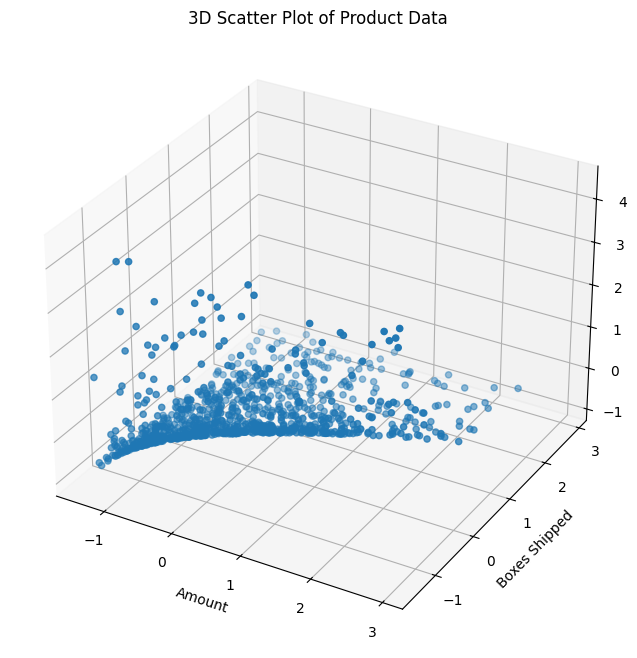

In [24]:
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(projection="3d")

scatter = ax.scatter(scaled_data_df["Amount"], scaled_data_df["Boxes Shipped"], scaled_data_df["Unit Price"])

ax.set_xlabel('Amount')
ax.set_ylabel('Boxes Shipped')
ax.set_zlabel('Unit Price')

ax.set_title('3D Scatter Plot of Product Data')

plt.show()

# Elbow Method (Menentukan K)

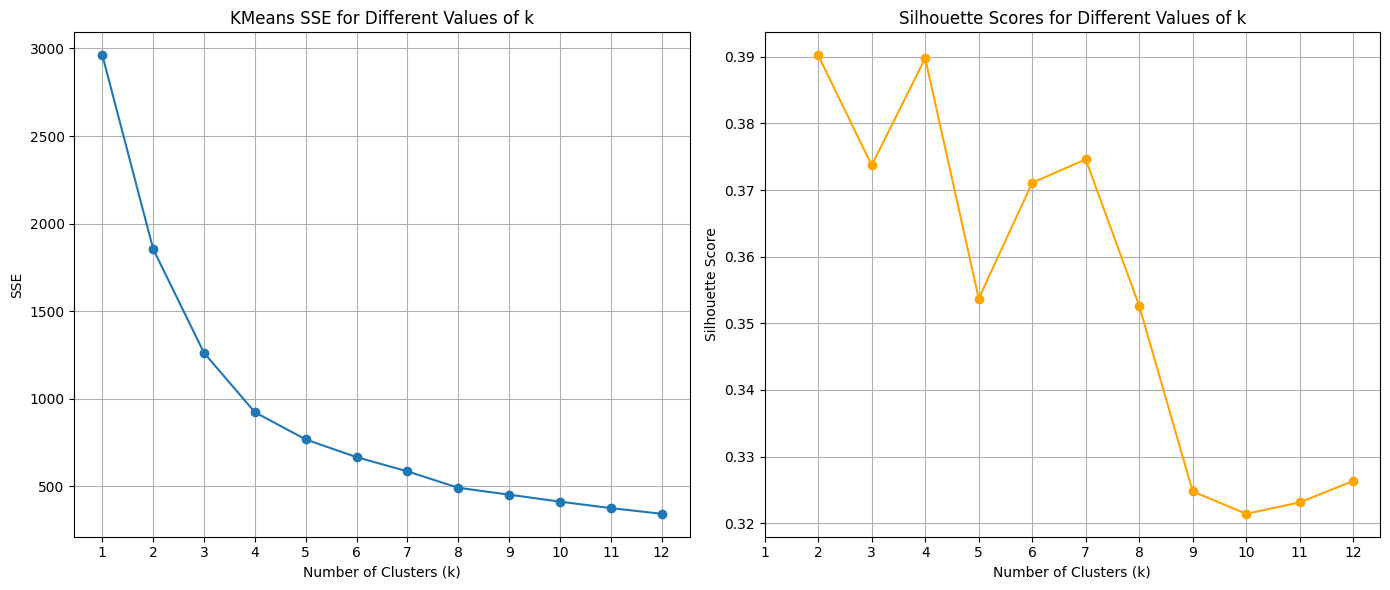

In [25]:
max_k = 12

sse = []
silhouette_scores = []
k_values = range(1, max_k + 1)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, max_iter=1000)
    cluster_labels = kmeans.fit_predict(scaled_data_df)
    
    # Simpan SSE
    sse.append(kmeans.inertia_)
    
    # Hitung silhouette score
    if k >= 2:
        sil_score = silhouette_score(scaled_data_df, cluster_labels)
        silhouette_scores.append(sil_score)
    else:
        silhouette_scores.append(None)  

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(k_values, sse, marker='o')
plt.title('KMeans SSE for Different Values of k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('SSE')
plt.xticks(k_values)
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(k_values, silhouette_scores, marker='o', color='orange')
plt.title('Silhouette Scores for Different Values of k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(k_values)
plt.grid(True)

plt.tight_layout()
plt.show()


In [26]:
kmeans = KMeans(n_clusters=4, random_state=42, max_iter=1000)

cluster_labels = kmeans.fit_predict(scaled_data_df)

In [27]:
non_outliers_df['Cluster'] = cluster_labels
non_outliers_df

C:\Users\Galen\AppData\Local\Temp\ipykernel_15972\395619450.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Sales Person,Country,Product,Date,Amount,Boxes Shipped,Unit Price,Cluster
0,Jehu Rudeforth,UK,Mint Chip Choco,2022-01-04,5320,180,29.555556,2
1,Van Tuxwell,India,85% Dark Bars,2022-08-01,7896,94,84.000000,3
2,Gigi Bohling,India,Peanut Butter Cubes,2022-07-07,4501,91,49.461538,2
3,Jan Morforth,Australia,Peanut Butter Cubes,2022-04-27,12726,342,37.210526,3
4,Jehu Rudeforth,UK,Peanut Butter Cubes,2022-02-24,13685,184,74.375000,3
...,...,...,...,...,...,...,...,...
1089,Karlen McCaffrey,Australia,Spicy Special Slims,2022-05-17,4410,323,13.653251,0
1090,Jehu Rudeforth,USA,White Choc,2022-06-07,6559,119,55.117647,3
1091,Ches Bonnell,Canada,Organic Choco Syrup,2022-07-26,574,217,2.645161,2
1092,Dotty Strutley,India,Eclairs,2022-07-28,2086,384,5.432292,0


In [28]:
centroids_scaled = kmeans.cluster_centers_
centroids_scaled

array([[-0.33373062,  1.3992938 , -0.67683801],
       [ 0.8313    , -1.07597391,  2.2098215 ],
       [-0.67617873, -0.50085157, -0.36165812],
       [ 1.13301836,  0.12168407,  0.13506004]])

In [29]:
centroids_original = scaler.inverse_transform(centroids_scaled)
centroids_original

array([[4020.65625   ,  308.30803571,   13.18375417],
       [8401.93495935,   49.05691057,  183.55172733],
       [2732.82692308,  109.29326923,   31.78537963],
       [9536.59375   ,  174.49553571,   61.10122565]])

In [30]:
centroids_ori = pd.DataFrame(centroids_original, columns=("Amount", "Boxes Shipped", "Unit Price"))
centroids_ori

,Amount,Boxes Shipped,Unit Price
0,4020.656250,308.308036,13.183754
1,8401.934959,49.056911,183.551727
2,2732.826923,109.293269,31.785380
3,9536.593750,174.495536,61.101226


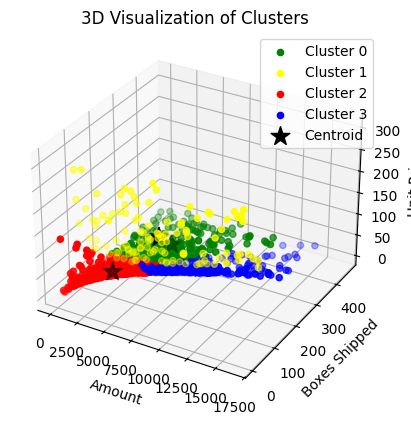

In [31]:
# subplot 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Data berdasarkan cluster
df1 = non_outliers_df[non_outliers_df.Cluster == 0]
df2 = non_outliers_df[non_outliers_df.Cluster == 1]
df3 = non_outliers_df[non_outliers_df.Cluster == 2]
df4 = non_outliers_df[non_outliers_df.Cluster == 3]

# Plot untuk tiap cluster
ax.scatter(df1.iloc[:, 4], df1.iloc[:, 5], df1.iloc[:, 6], color='green', label='Cluster 0')
ax.scatter(df2.iloc[:, 4], df2.iloc[:, 5], df2.iloc[:, 6], color='yellow', label='Cluster 1')
ax.scatter(df3.iloc[:, 4], df3.iloc[:, 5], df3.iloc[:, 6], color='red', label='Cluster 2')
ax.scatter(df4.iloc[:, 4], df4.iloc[:, 5], df4.iloc[:, 6], color='blue', label='Cluster 3')

# Plot untuk centroid
ax.scatter(centroids_original[:, 0], 
           centroids_original[:, 1], 
           centroids_original[:, 2], 
           color='black', label='Centroid', marker='*', s=200)

# Label dan title
ax.set_xlabel('Amount')  
ax.set_ylabel('Boxes Shipped')  
ax.set_zlabel('Unit Price')  
ax.set_title('3D Visualization of Clusters')


ax.legend()


plt.show()


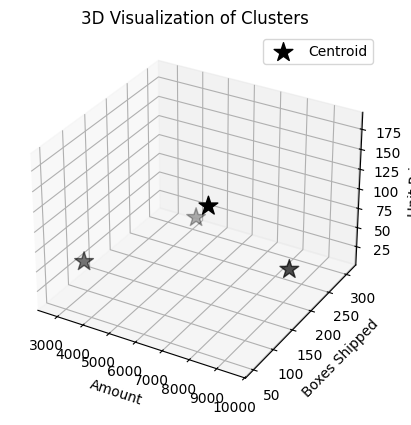

In [32]:
# subplot 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot untuk centroid
ax.scatter(centroids_original[:, 0], 
           centroids_original[:, 1], 
           centroids_original[:, 2], 
           color='black', label='Centroid', marker='*', s=200)

# Label dan title
ax.set_xlabel('Amount')  
ax.set_ylabel('Boxes Shipped')  
ax.set_zlabel('Unit Price')  
ax.set_title('3D Visualization of Clusters')

# Menambahkan legend
ax.legend()

# Menampilkan plot
plt.show()


In [33]:
overlap_indices = amount_outliers_df.index.intersection(boxesshipped_outliers_df.index)

amount_only_outliers = amount_outliers_df.drop(overlap_indices)
boxesshipped_only_outliers = boxesshipped_outliers_df.drop(overlap_indices)
amount_and_boxesshipped_outliers = amount_outliers_df.loc[overlap_indices]

amount_only_outliers["Cluster"] = -1
boxesshipped_only_outliers["Cluster"] = -2
amount_and_boxesshipped_outliers["Cluster"] = -3

outlier_clusters_df = pd.concat([amount_only_outliers, boxesshipped_only_outliers, amount_and_boxesshipped_outliers])

outlier_clusters_df.head()

,Sales Person,Country,Product,Date,Amount,Boxes Shipped,Unit Price,Cluster
57,Brien Boise,Canada,99% Dark & Pure,2022-05-18,16793,416,40.367788,-1
66,Van Tuxwell,Australia,Organic Choco Syrup,2022-08-10,19453,14,1389.500000,-1
119,Kelci Walkden,USA,Manuka Honey Choco,2022-02-16,17318,87,199.057471,-1
135,Van Tuxwell,India,Organic Choco Syrup,2022-05-16,19929,174,114.534483,-1
212,Marney O'Breen,UK,Smooth Sliky Salty,2022-05-13,18991,88,215.806818,-1


In [34]:
full_clustering_df = pd.concat([non_outliers_df, outlier_clusters_df])

full_clustering_df

,Sales Person,Country,Product,Date,Amount,Boxes Shipped,Unit Price,Cluster
0,Jehu Rudeforth,UK,Mint Chip Choco,2022-01-04,5320,180,29.555556,2
1,Van Tuxwell,India,85% Dark Bars,2022-08-01,7896,94,84.000000,3
2,Gigi Bohling,India,Peanut Butter Cubes,2022-07-07,4501,91,49.461538,2
3,Jan Morforth,Australia,Peanut Butter Cubes,2022-04-27,12726,342,37.210526,3
4,Jehu Rudeforth,UK,Peanut Butter Cubes,2022-02-24,13685,184,74.375000,3
...,...,...,...,...,...,...,...,...
865,Kaine Padly,New Zealand,Smooth Sliky Salty,2022-04-12,7,518,0.013514,-2
875,Beverie Moffet,New Zealand,Drinking Coco,2022-01-12,1141,518,2.202703,-2
978,Mallorie Waber,Canada,Caramel Stuffed Bars,2022-06-10,4844,539,8.987013,-2
1028,Van Tuxwell,Canada,Drinking Coco,2022-06-15,4900,709,6.911142,-2


In [35]:
filtered_df = full_clustering_df[full_clustering_df['Cluster'].isin([0, 1, 2, 3])]


cluster_dist = (
    filtered_df.groupby(['Country', 'Cluster'])
    .size()
    .reset_index(name='Jumlah')
)


cluster_dist['Cluster'] = cluster_dist['Cluster'].astype(str)


fig = px.bar(cluster_dist,
             x='Country',
             y='Jumlah',
             color='Cluster',
             barmode='group',
             title='Distribusi Cluster 0–3 per Country',
             labels={'Jumlah': 'Jumlah Data'},
             text_auto=True,
             color_discrete_sequence=px.colors.qualitative.Pastel)


fig.update_layout(
    template='plotly_white',
    xaxis_tickangle=0,
    legend_title='Cluster',
    margin=dict(l=40, r=30, t=60, b=40)
)

fig.show()

# KESIMPULAN

1. Cluster 0 (Low Volume Explorers)
   - Ciri Khas:
        * Konsumen dengan jumlah pembelian rendah dan frekuensi kecil.
   - Tindak lanjut
        * Edukasi produk melalui campaign awareness, dorong upselling dengan diskon awal.

2. Cluster 1 (Mass Buyers)
   - Ciri Khas:
        * Konsumen dengan kuantitas beli besar, tapi nilai per unit rendah.
   - Tindak lanjut
        * Optimalkan distribusi dan logistik, tawarkan bundling ekonomis.

3. Cluster 1 (Premium Loyalists)
   - Ciri Khas:
        * Konsumen yang membeli produk dengan harga per unit tinggi secara konsisten.
   - Tindak lanjut
        * Tawarkan program loyalitas atau early-access produk premium.

3. Cluster 1 (Price-Sensitive Testers)
   - Ciri Khas:
        * Konsumen yang membeli dengan volume kecil dan cenderung mencoba produk baru.
   - Tindak lanjut
        * Tawarkan promo first-time buyer, lakukan A/B testing untuk promo harga.